In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cs109.model import KNNAnomalyDetector

%matplotlib inline

## Building intuition

### Sample 1: consist of a cluster of 100 points of stretched Gaussian data and a straight line of 10 points going avay from the cluster. 

In [2]:
def gen_data1(mult = 1.0):
    C = np.array([[1., 3.7], [3.5, 5.7]])
    d1 = np.dot(np.random.randn(90, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.column_stack((np.linspace(20., 30.*mult, num = 10), np.linspace(20., 10.*mult, num = 10)))
    ))
    return d1, d2

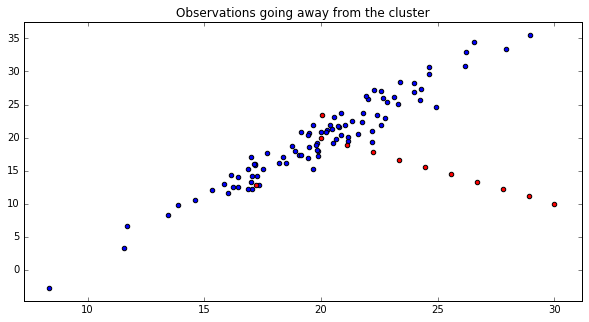

In [3]:
cluster1, line1 = gen_data1()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster1[:, 0], cluster1[:, 1], c='blue')
ax.scatter(line1[:, 0], line1[:, 1], c='red')
ax.set_title('Observations going away from the cluster')
a = ax.axis('tight')

### Sample 2: consist of a cluster of 30 points (less dense) of stretched Gaussian data and anothe cluster of 20 points building outside the main cluster.

In [4]:
def gen_data2(mult = 1.0):
    C = np.array([[1.5, 3.7], [2.5, 2.7]])
    d1 = np.dot(np.random.randn(30, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.dot(np.random.randn(20, 2), np.array([[.7, 0.2], [.5, .8]])) + np.array([35*mult, 5*mult])
        ))
    return d1, d2

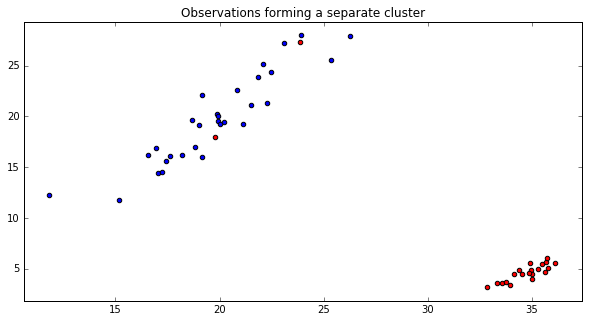

In [5]:
cluster2, cluster3 = gen_data2()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster2[:, 0], cluster2[:, 1], c='blue')
ax.scatter(cluster3[:, 0], cluster3[:, 1], c='red')
ax.set_title('Observations forming a separate cluster')
a = ax.axis('tight')

In [6]:
def plot_results(data1, data2, r):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(data1[:, 0], data1[:, 1], c='blue')
    ax1.scatter(data2[:, 0], data2[:, 1], c='red')
    ax1.axis('tight')

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(r[:, 0])
    ax2.set_title('Strangeness')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(r[:, 1])
    ax3.set_title('P-value')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(r[:, 2])
    ax3.set_title('Martingale')    

In [7]:
def perform_experiment(model, data1, data2):
    for x in data1:
        model.observe(x)
    results = []
    for x in data2:
        results.append(model.observe(x))
    r = np.array(results)
    plot_results(data1, data2, r)

## Model with default values
- the neighborhood consists of 3 neighbors
- density calculated relatively to total density in the neighborhood
- euclidean distance is used
- epsilon = 0.92

### Sample 1: Observations moving away 

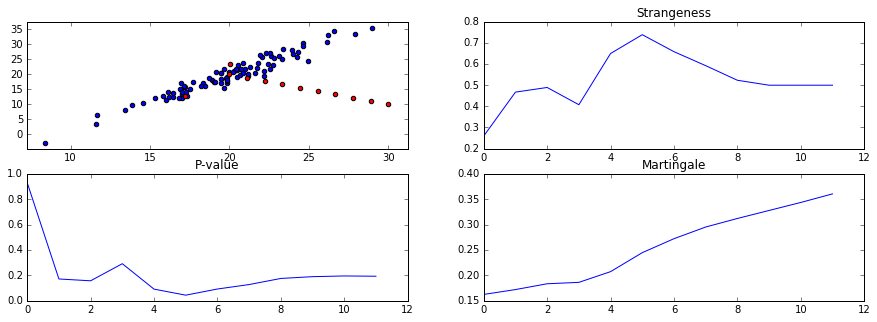

In [8]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster1, line1)

In this experiment we could observe how the strangeness measure (relative density) goes up, the p-value goes down and the martingale builds confidence in the underlying change by gorowing up. 

### Sample 2: Observations forming a separate cluster

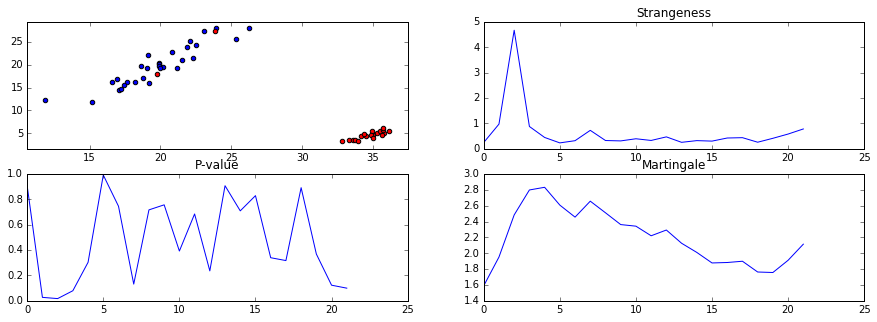

In [9]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster2, cluster3)

This experiment perhaps highlights a possible weaknes in our model: small neighborhood size could prevent us from detecting underlying change in the data steram! In this case as soon as number of observation in the separate cluster reached the neighborhood size the relative dencity went down and the martingale had not time to build the confidense!  
The good new is that we have n_neighbors parameter to fight this problem (maybe others as well).

## The neighborhood size

### Sample 1: Observations moving away 

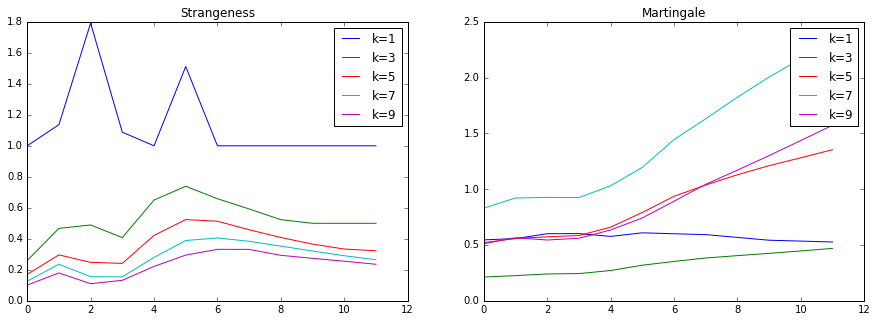

In [10]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster1:
        detector.observe(x)
    results = []
    for x in line1:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()

### Sample 2: Observations forming a separate cluster

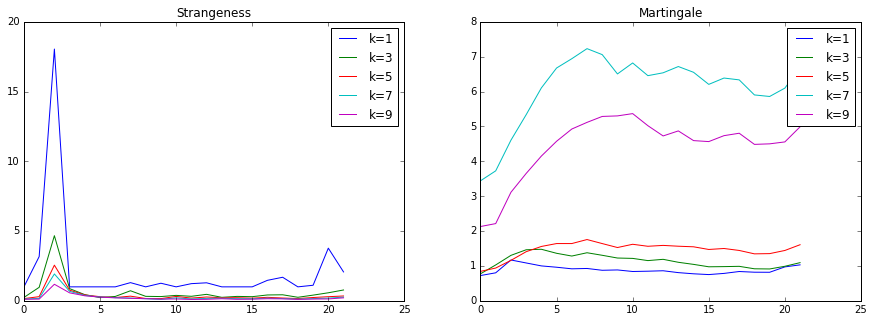

In [11]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster2:
        detector.observe(x)
    results = []
    for x in cluster3:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()

Some observations:
- our default martingale calculation is not very sensitive to the sharp but short lived changes of the strangeness measure;
- change in the neighborhood size might have a lot of influence on the relative density calculation and the martingale value;

## The epsilon value

Initial martingale value $M_{0} = 1.0$ and with every new observation we calculate martingale value as $M_{n} = \epsilon p_{n}^{(\epsilon - 1)} M_{n - 1}$ where $p$ is the p-value.  
Let's simulate a stream of p-values perhaps indicating some change in the middle of the stream and observe changes in the martingale value for different epsilon values.

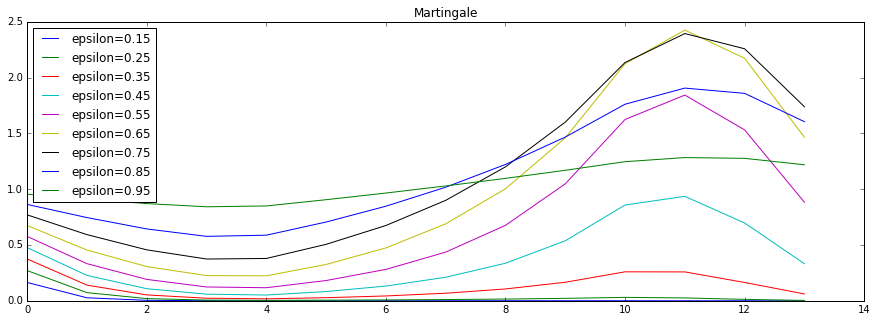

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Martingale')

P = np.array([0.9, 0.9, 0.9, 0.7, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.4, 0.9])

for epsilon in np.linspace(0.15, 0.95, num = 9):
    m = 1.0
    M = []
    for p in P:
        m = m*epsilon*np.power(p, epsilon - 1.0)
        M.append(m)
    ax.plot(M, label = 'epsilon=' + str(epsilon))
ax.legend(loc='best')

The real change happens at step five and the martingales reach maximum value around step 11.
It looks like best performing epsilon values would be in 0.75 - 0.95 range.
It is obvious the martingale is used to build a confidence level by receiving quite a few small p-values. That might not work very well in conjunction with KNN-based metrics as the strangeness measure might go down as soon as the new neighborhood is built.

## Tuning the defaut model with epsilon and the neighborhood size

### Sample 1: Observations moving away 

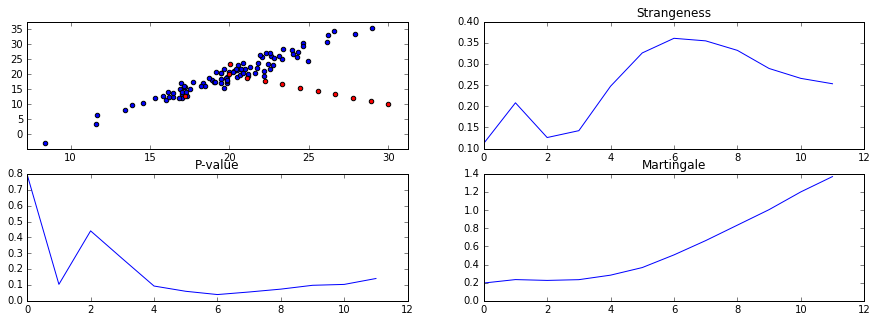

In [13]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster1, line1)

### Sample 2: Observations forming a separate cluster

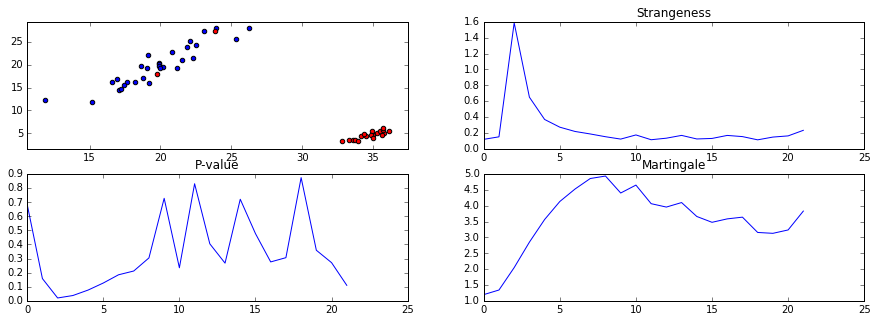

In [14]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster2, cluster3)

We already have better models detecting both anomalies.

## Different distance metrics

Our class accepts the following distance metrics:  

- 'euclidean' EuclideanDistance:  $sqrt(sum((x - y)^2))$
- 'manhattan' ManhattanDistance:  $sum(|x - y|)$
- 'chebyshev' ChebyshevDistance   $max(|x - y|)$

### With Manhattan distance

### Sample 1: Observations moving away 

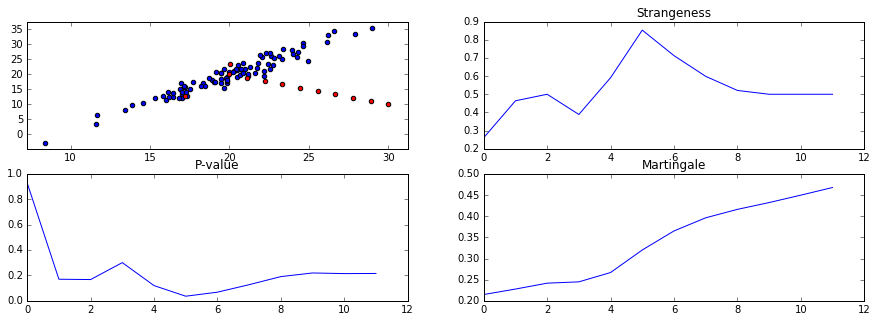

In [15]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster1, line1)

### Sample 2: Observations forming a separate cluster

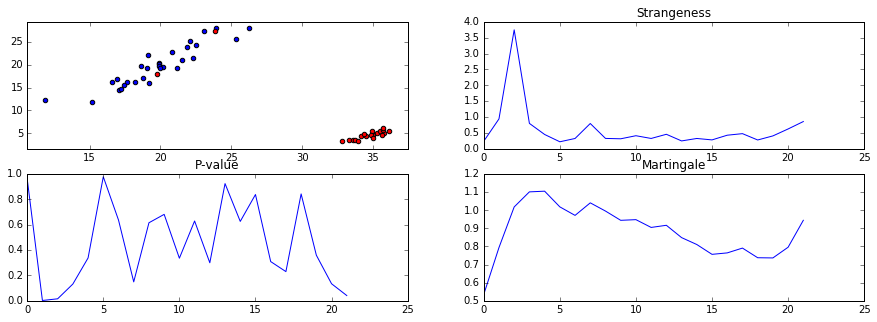

In [16]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster2, cluster3)

### With Chebyshev distance

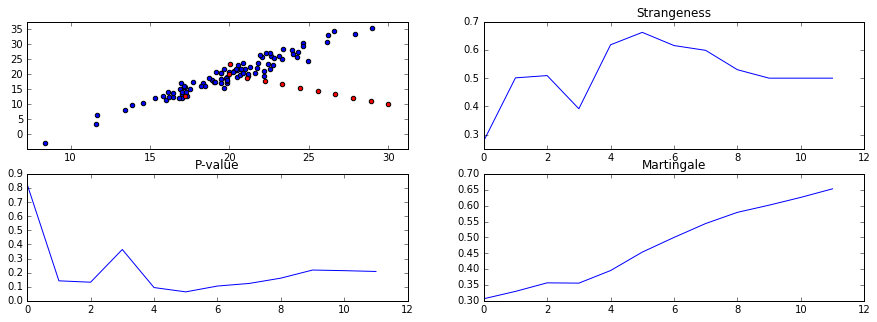

In [17]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster1, line1)

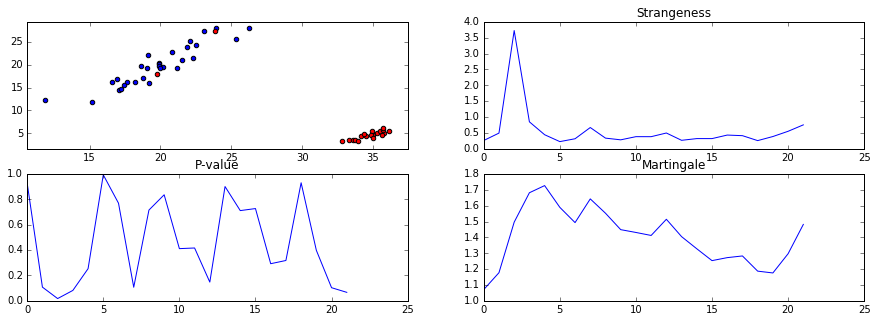

In [18]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster2, cluster3)

I think in our experiment it is not so obvious which distance should be used and why,  but when we work with real high dimensonal data we should try all of them.

### Density vs proximity

### Sample 1: Observations moving away 

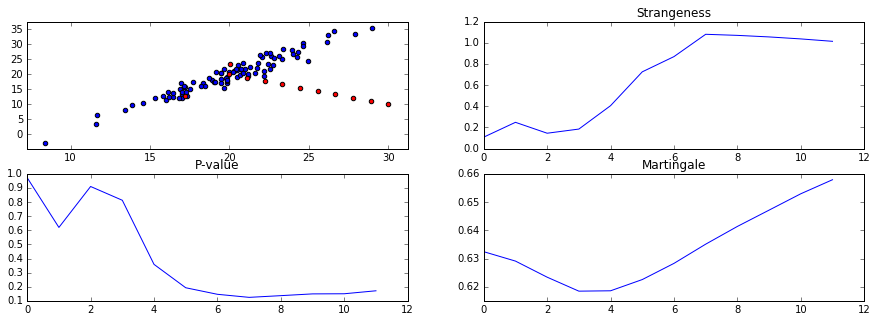

In [ ]:
model = KNNAnomalyDetector(method='proximity', epsilon = 0.99)
perform_experiment(model, cluster1, line1)

### Sample 2: Observations forming a separate cluster

In [ ]:
model = KNNAnomalyDetector(method='proximity', metric='manhattan', epsilon = 0.99)
perform_experiment(model, cluster2, cluster3)

Proximity strnageness measure seams to be a weaker option, perhaps more investigation should be done to understand where it is applicable.